<a href="https://colab.research.google.com/github/alunfes/1m-btc-data/blob/master/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
print(tf.__version__)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, timezone
from sklearn.model_selection import train_test_split
import time
import random

from keras.models import Sequential, Model
from keras.layers import InputLayer, Input, Dense, Dropout, Conv1D, MaxPooling1D, BatchNormalization, Flatten, AveragePooling1D, concatenate, Flatten, TimeDistributed
from keras import optimizers,regularizers
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

2.9.2


In [3]:
class MarketData:
    @classmethod
    def initialize(cls):
        cls.df = pd.DataFrame()
        cls.ts = []
        cls.open = []
        cls.high = []
        cls.low = []
        cls.close = []
        cls.vol = []
        cls.__read_data()
        cls.logopen = list(np.log(cls.open))
        cls.loghigh = list(np.log(cls.high))
        cls.loglow = list(np.log(cls.low))
        cls.logclose = list(np.log(cls.close))
        cls.close_change_ratio = list(np.array(pd.DataFrame(cls.close).pct_change().values.tolist()).reshape(len(cls.close)))
        cls.logclose_change_ratio = list(np.array(pd.DataFrame(cls.logclose).pct_change().values.tolist()).reshape(len(cls.logclose)))
    
    @classmethod
    def __read_data(cls):
        cls.df = pd.read_csv('/content/drive/My Drive/BTC-PERP-1mcp.csv')
        cls.ts = list(cls.df['ts'])
        cls.open = list(cls.df['open'])
        cls.high = list(cls.df['high'])
        cls.low = list(cls.df['low'])
        cls.close = list(cls.df['close'])
        cls.vol = list(cls.df['volume'])
    

In [4]:
MarketData.initialize()

In [5]:
#generate minmax sacled data of input / output for auto encoder
def DataGenerator(from_ind, to_ind, data_length, sampling_window):
    x = []
    y = []
    current_start = from_ind
    mmsc = MinMaxScaler(feature_range=(0,1), copy=True)
    while True:
        x.append(mmsc.fit_transform(np.array(MarketData.logclose_change_ratio[current_start : current_start + data_length]).reshape(-1,1)))
        y.append(mmsc.fit_transform(np.array(MarketData.logclose_change_ratio[current_start : current_start + data_length]).reshape(-1,1)))
        current_start += sampling_window
        if current_start >= to_ind:
            break
    return x, y
data_length = 30
x, y = DataGenerator(100000, 1300000, data_length, 500)

In [6]:
#tx = tf.data.Dataset.from_tensor_slices(x)
#ty = tf.data.Dataset.from_tensor_slices(y)

In [7]:
train_x, test_x = train_test_split(np.array(x), test_size=0.2, shuffle=False)
train_y, test_y = train_test_split(np.array(y), test_size=0.2, shuffle=False)
train_x = np.squeeze(train_x)
test_x = np.squeeze(test_x)
train_y = np.squeeze(train_y)
test_y = np.squeeze(test_y)
print('train_x shape=', train_x.shape)
print('test_x shape=', test_x.shape)
print('train_y shape=', train_y.shape)
print('test_y shape=', test_y.shape)

train_x shape= (1920, 30)
test_x shape= (480, 30)
train_y shape= (1920, 30)
test_y shape= (480, 30)


In [8]:
early_stopping = EarlyStopping(patience=10)
input = Input(shape=(data_length,))
encoder = Dense(data_length, activation='softsign')(input)
encoder = BatchNormalization()(encoder)
encoder = Dense(round(data_length * 0.5), activation='softsign')(encoder)
encoder = BatchNormalization()(encoder)
encoder = Dense(data_length, activation='softsign')(encoder)
encoder = BatchNormalization()(encoder)
decoder = Dense(data_length, activation = 'sigmoid')(encoder)
model = Model(inputs=input, outputs=decoder)
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])
display(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 30)                930       
                                                                 
 batch_normalization (BatchN  (None, 30)               120       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 15)                465       
                                                                 
 batch_normalization_1 (Batc  (None, 15)               60        
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 30)                480   

None

In [9]:
hist = model.fit(train_x, train_y, validation_split=0.1, epochs=200, callbacks=[early_stopping])
print(model.evaluate(test_x, test_y))

Epoch 1/200
54/54 [==============================] - 1s 5ms/step - loss: 0.0781 - accuracy: 0.0590 - val_loss: 0.0616 - val_accuracy: 0.0781
Epoch 2/200
54/54 [==============================] - 0s 2ms/step - loss: 0.0472 - accuracy: 0.1291 - val_loss: 0.0585 - val_accuracy: 0.1510
Epoch 3/200
54/54 [==============================] - 0s 2ms/step - loss: 0.0403 - accuracy: 0.2147 - val_loss: 0.0525 - val_accuracy: 0.1927
Epoch 4/200
54/54 [==============================] - 0s 2ms/step - loss: 0.0367 - accuracy: 0.2407 - val_loss: 0.0456 - val_accuracy: 0.2240
Epoch 5/200
54/54 [==============================] - 0s 2ms/step - loss: 0.0348 - accuracy: 0.2581 - val_loss: 0.0406 - val_accuracy: 0.2448
Epoch 6/200
54/54 [==============================] - 0s 2ms/step - loss: 0.0333 - accuracy: 0.2743 - val_loss: 0.0376 - val_accuracy: 0.2344
Epoch 7/200
54/54 [==============================] - 0s 2ms/step - loss: 0.0322 - accuracy: 0.2975 - val_loss: 0.0355 - val_accuracy: 0.2760
Epoch 8/200
5

In [20]:
early_stopping = EarlyStopping(patience=10)
input = Input(shape=(data_length,))
decoder = LSTM(30, input_shape=(round(data_length * 0.5), 1), activation='tanh', return_sequences=False)(input)
decoder = Dense(data_length, activation='tanh')(decoder)
model = Model(inputs=input, outputs=decoder)
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])
display(model.summary())

ValueError: ignored

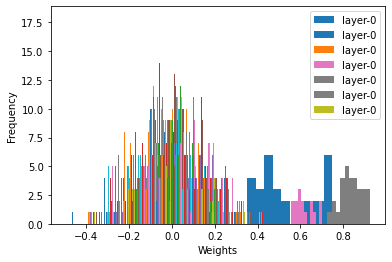

In [11]:
def displayWeightsHist(nn_model):
    fig, ax = plt.subplots()
    data = []
    col = []
    i = 0
    for layer in nn_model.layers:
        if len(layer.get_weights()) > 0:
            data.append(layer.get_weights()[0])
            col.append('layer-'+str(i))
            ax.hist(data[-1], label=col[-1], bins=10)
    ax.set_xlabel('Weights')
    ax.set_ylabel('Frequency')
    ax.legend()
    plt.show()
displayWeightsHist(model)

In [12]:
res = model.predict(train_x)

60/60 [==============================] - 0s 976us/step


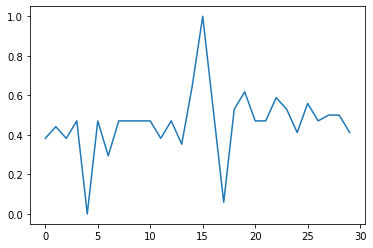

In [13]:
plt.plot(train_x[10])

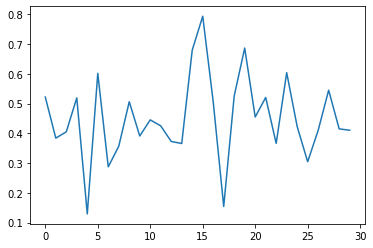

In [14]:
plt.plot(res[10])

In [85]:
tra

[6, 9, 8, 10, 1, 3, 4, 7]

In [87]:
tes

[2, 5]